In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from binance.client import Client
from config import myconfig

# Read API keys
API_KEY = myconfig.BINANCE_API_KEY
API_SECRET = myconfig.BINANCE_API_SECRET

client = Client(API_KEY, API_SECRET)

# Fetch historical data for a given symbol
def get_binance_data(symbol, interval, lookback):
    klines = client.get_klines(symbol=symbol, interval=interval, limit=lookback)
    df = pd.DataFrame(klines, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume', 
        'close_time', 'quote_asset_volume', 'num_trades', 
        'taker_buy_base', 'taker_buy_quote', 'ignore'
    ])
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    
    # Convert 'close' column to float
    df['close'] = df['close'].astype(float)

    return df[['timestamp', 'close']].set_index('timestamp')

# Set parameters
interval = client.KLINE_INTERVAL_1HOUR
lookback = 500

# Get data for BTC/USDT and ETH/USDT
btc_data = get_binance_data('BTCUSDT', interval, lookback)
eth_data = get_binance_data('ETHUSDT', interval, lookback)

# Merge data on timestamps
df = btc_data.join(eth_data, lsuffix='_btc', rsuffix='_eth', how='inner')

# Calculate correlation
correlation = df.corr().iloc[0, 1]
print(f"BTC-ETH Correlation (last {lookback} periods): {correlation:.4f}")


BTC-ETH Correlation (last 500 periods): 0.9417


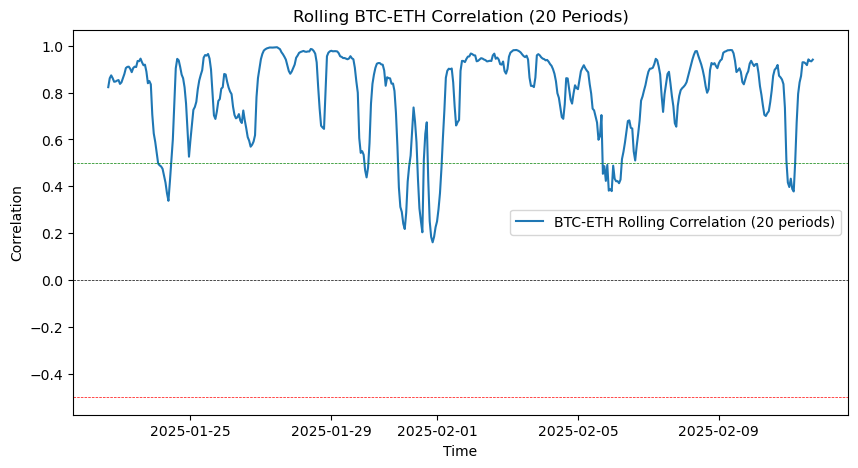

In [3]:
import matplotlib.pyplot as plt

# Calculate rolling correlation (e.g., over 20 periods)
df['rolling_corr'] = df['close_btc'].rolling(window=20).corr(df['close_eth'])

# Plot rolling correlation
plt.figure(figsize=(10,5))
plt.plot(df.index, df['rolling_corr'], label='BTC-ETH Rolling Correlation (20 periods)')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axhline(0.5, color='green', linestyle='--', linewidth=0.5)
plt.axhline(-0.5, color='red', linestyle='--', linewidth=0.5)
plt.legend()
plt.title('Rolling BTC-ETH Correlation (20 Periods)')
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.show()
